<xarray.Dataset>
Dimensions:       (time_ls: 103, lay: 140, lev: 141, time_surface: 103,
                   time_nudge: 103, time_latlon: 103, z: 151, zh: 152)
Coordinates:
  * time_ls       (time_ls) float64 0.0 1.0 2.0 3.0 ... 99.0 100.0 101.0 102.0
  * time_surface  (time_surface) float64 0.0 3.6e+03 ... 3.636e+05 3.672e+05
  * time_nudge    (time_nudge) float64 0.0 1.0 2.0 3.0 ... 100.0 101.0 102.0
  * time_latlon   (time_latlon) float64 0.0 3.6e+03 ... 3.636e+05 3.672e+05
Dimensions without coordinates: lay, lev, z, zh
Data variables: (12/24)
    p_lay         (time_ls, lay) float64 ...
    p_lev         (time_ls, lev) float64 ...
    t_lay         (time_ls, lay) float64 ...
    t_lev         (time_ls, lev) float64 ...
    o3_bg         (time_ls, lay) float64 ...
    h2o_bg        (time_ls, lay) float64 ...
    ...            ...
    qt_sbot       (time_surface) float64 ...
    p_sbot        (time_surface) float64 ...
    lat           (time_latlon) float64 ...
    lon           (time_latlon) float64 ...
    utrans        (time_latlon) float64 ...
    vtrans        (time_latlon) float64 ...

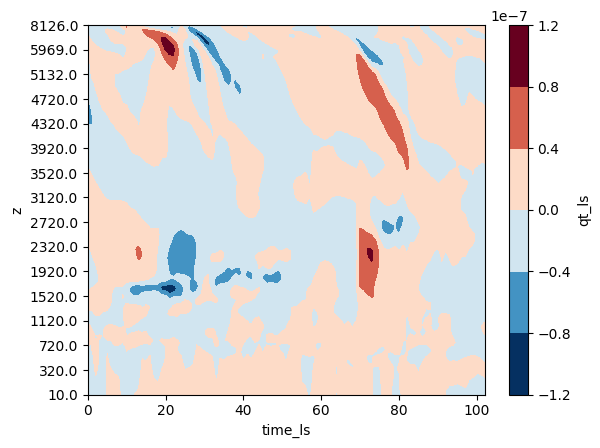

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
import open_xarray as ox

file_path='/fs/ess/PFS0220/eurec4a/Case_Runs/Control_Runs/Feb_9th/eurec4a_input.nc'
ds=xr.open_dataset(file_path,group='timedep',decode_times=False)
ds2=xr.open_dataset(file_path,decode_times=False)

ds['time_nudge']=ds.time_nudge/3600
ds['time_ls']=ds.time_ls/3600
pl.figure()
#ds.time_ls=ds.time_ls/3600
ds.qt_ls.isel(z=slice(0,160)).plot.contourf(x='time_ls')
pl.yticks(np.arange(0,160,10),ds2.z.isel(z=slice(0,160,10)).values)

ds

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as pl
import open_xarray as ox

ds2=xr.open_dataset('/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200209.kpt.nc',decode_times=True)
ds2



<xarray.Dataset>
Dimensions:         (time: 103, nlev: 249, nlevp1: 250, nlevs: 4, nDS: 1)
Coordinates:
  * time            (time) datetime64[ns] 2020-02-06 ... 2020-02-10T06:00:00
  * nlev            (nlev) float64 1.0 2.0 3.0 4.0 ... 246.0 247.0 248.0 249.0
  * nlevp1          (nlevp1) float64 1.0 2.0 3.0 4.0 ... 247.0 248.0 249.0 250.0
  * nlevs           (nlevs) float64 1.0 2.0 3.0 4.0
  * nDS             (nDS) int64 0
Data variables: (12/84)
    zf              (time, nlev) float64 ...
    zh              (time, nlevp1) float64 ...
    ps              (time) float64 ...
    pres            (time, nlev) float64 ...
    presh           (time, nlevp1) float64 ...
    u               (time, nlev) float64 ...
    ...              ...
    DS              (nDS) <U17 ...
    timDS           (nDS) datetime64[ns] ...
    latDS           (nDS) float64 ...
    lonDS           (nDS) float64 ...
    second          (time) float64 ...
    date            (time) timedelta64[ns] ...
Attributes:
    campaign:        eurec4a_ext
    flight:          n/a
    date:            2020-02-09T10:00:00.000000000
    source:          ERA5
    source_domain:   NEEDS ADDING
    source_grid:     grid0.1x0.1
    creator:         Thijs Heus with https://github.com/EUREC4A-UK/lagtraj
    created:         2023-09-23T04:34:50.287386
    wilting_point:   0.1715
    field_capacity:  0.32275

In [1]:
import sys

import numpy as np
import netCDF4 as nc
import xarray as xr
import math


float_type = 'f8'

def create_microhhforcing(netcdf_path,output_path,tstart,z_top,sst_p,cluster,nudge_height):
    sys.path.append('/usr/local/lib/python3.8/dist-packages/metpy')
    import metpy.calc as mpcalc
    from metpy.units import units
    if cluster=='cumulus':
        sys.path.append('/home/girish/microhh_lagtraj/microhh/python')
    elif cluster=='osc':
        sys.path.append('/users/PFS0220/graghuna/microhh/microhh_lagtraj/microhh/python')
    import os
    import microhh_tools as mht

    ############################## get forcing data from nc input #################################### 
    #netcdf_path = '~/microhh/microhh/cases/eurec4a/forcings/scm_in.ECMWF-fc_EUREC4A_coor-Lagrangian-traj1-p950_domain2.0x2.0_20200202_ndays5_sfcERA5.nc'
    #netcdf_path = '/data/eurec4a/data/forcings/new_domain.kpt.nc'
    ts = tstart;
    all_data = xr.open_dataset(netcdf_path,decode_times=False)
    time = all_data['time'].values[0:];
    tn=all_data['time'].values[:].size 
    pres0_m=all_data['ps'].values[0:];
    select_arr=np.logical_and(np.logical_not(np.isnan(pres0_m)),(time>=time[ts]))
    qadv_un=all_data['qadv'].values[select_arr,:];             qadv_un=np.flip(qadv_un, axis=1);
    tadv_un=all_data['tadv'].values[select_arr,:];             tadv_un=np.flip(tadv_un, axis=1);
    uadv_un=all_data['uadv'].values[select_arr,:];             uadv_un=np.flip(uadv_un, axis=1);
    vadv_un=all_data['vadv'].values[select_arr,:];             vadv_un=np.flip(vadv_un, axis=1);
    qt_un=all_data['q'].values[select_arr,:];                  qt_un=np.flip(qt_un, axis=1);
    ql_un=all_data['ql'].values[select_arr,:];                 ql_un=np.flip(ql_un, axis=1);
    u_un=all_data['u'].values[select_arr,:];                   u_un=np.flip(u_un, axis=1);
    v_un=all_data['v'].values[select_arr,:];                   v_un=np.flip(v_un, axis=1);
    ug_un=all_data['ug'].values[select_arr,:];                 ug_un=np.flip(ug_un, axis=1);
    vg_un=all_data['vg'].values[select_arr,:];                 vg_un=np.flip(vg_un, axis=1);
    if 'height_f' in all_data.keys():
        zun=all_data['height_f'].values[select_arr,:];             zun=np.flip(zun, axis=1);
    else:
        zun=all_data['zf'].values[select_arr,:];             zun=np.flip(zun, axis=1);
    
    if 'pressure_f' in all_data.keys():
        pres_un=all_data['pressure_f'].values[select_arr,:];       pres_un=np.flip(pres_un, axis=1);
    else:
        pres_un=all_data['pres'].values[select_arr,:];       pres_un=np.flip(pres_un, axis=1);
    T_un=all_data['t'].values[select_arr,:];                   T_un=np.flip(T_un, axis=1);
    pres0=all_data['ps'].values[select_arr];
    sst=all_data['open_sst'].values[select_arr];
    if sst_p:
        sst=sst+0.5;
    H=all_data['sfc_sens_flx'].values[select_arr];
    LE = all_data['sfc_lat_flx'].values[select_arr];
    omega_un = all_data['omega'].values[select_arr,:];         omega_un=np.flip(omega_un, axis=1);
    o3_un = all_data['o3'].values[select_arr,:];               o3_un=np.flip(o3_un, axis=1);
    time = all_data['time'].values[select_arr];
    lon = all_data['lon'].values[select_arr]; 
    lat = all_data['lat'].values[select_arr];
    albedo=all_data['albedo'].values[select_arr];
    z0m=all_data['mom_rough'].values[select_arr];
    z0h=all_data['heat_rough'].values[select_arr];
    
    # set the height
    z_new=np.zeros(300)
    dz=20
    z_new[0]=10;
    for i in range(1,z_new.size): 
        z_new[i]=z_new[i-1]+dz
        if i<7:
            dz=dz+int(round(0.1*dz,0));
        elif i==7:
            z_new[i]=200;
            dz=40;
        elif z_new[i]>7000:
            dz=dz+int(round(0.1*dz,0));
    z_end_ind=np.nonzero((z_new>z_top))[0][0]
    z=z_new[0:z_end_ind+1]
    kmax=z.size

    zh = 0.5*(z[:-1] + z[1:])
    zh = np.append(0., zh)
    zh = np.append(zh, z_new[z_end_ind+1])

    time = time - time[0];
    ############################## Declare input variables to nc input and constants ##################################

    sat_r = np.zeros(time.size)
    qt_bot = np.zeros(time.size)
    sbotthl = np.zeros(time.size)

    u = np.zeros((time.size, kmax))
    v = np.zeros(np.shape(u))
    ugeo = np.zeros(np.shape(u))
    vgeo = np.zeros(np.shape(u))
    qt = np.zeros(np.shape(u))
    ql = np.zeros(np.shape(u))
    qadv = np.zeros(np.shape(u))
    tadv = np.zeros(np.shape(u))
    uadv = np.zeros(np.shape(u))
    vadv = np.zeros(np.shape(u))
    th = np.zeros(np.shape(u))
    thl   = np.zeros(np.shape(u))
    thlls = np.zeros(np.shape(u))
    qtls = np.zeros(np.shape(u))
    w   = np.zeros(np.shape(u))
    uls = np.zeros(np.shape(u))
    vls = np.zeros(np.shape(u))
    wls = np.zeros((time.size, kmax+1))
    pres = np.zeros(np.shape(u))
    omega = np.zeros(np.shape(u))
    o3_f = np.zeros(np.shape(u))
    T = np.zeros(np.shape(u))
    nudge_factor = np.zeros(np.shape(u))
    th_diff = np.zeros(time.size)
    qt_diff = np.zeros(time.size)
    U = np.zeros(time.size)

    cp  = 1005.
    Lv  = 2.5e6
    Rd  = 287.
    tau = 21600;


    ######################## Radiation Calculation and NC input ##################################

    ######## Calculation and Interpolation of Radiation Variables ############
    z_top = 70.e3
    dz = 500.
    z_rad  = np.arange(dz/2, z_top, dz)
    zh_rad = np.arange(   0, z_top-dz/2, dz)
    zh_rad = np.append(zh_rad, z_top)
    

    p_lay=np.zeros((time.size,z_rad.size)); p_lev=np.zeros((time.size,zh_rad.size));
    T_lay=np.zeros((time.size,z_rad.size)); T_lev=np.zeros((time.size,zh_rad.size));
    qt_rad=np.zeros((time.size,z_rad.size)); o3_rad=np.zeros((time.size,z_rad.size));
    
    p_lay_bg=np.zeros((time.size,z.size)); p_lev_bg=np.zeros((time.size,zh.size));
    T_lay_bg=np.zeros((time.size,z.size)); T_lev_bg=np.zeros((time.size,zh.size));
    qt_rad_bg=np.zeros((time.size,z.size)); o3_rad_bg=np.zeros((time.size,z.size));

    for i in range(0,time.size):
        interp_rad=(np.logical_not(np.isnan(zun[i,:])))
        p_lay[i,:] = np.interp(z_rad,zun[i,interp_rad],pres_un[i,interp_rad])
        p_lev[i,:] = np.interp(zh_rad,zun[i,interp_rad],pres_un[i,interp_rad])
        T_lay[i,:] = np.interp(z_rad,zun[i,interp_rad],T_un[i,interp_rad])
        T_lev[i,:] = np.interp(zh_rad,zun[i,interp_rad],T_un[i,interp_rad])
        qt_rad[i,:] = np.interp(z_rad,zun[i,interp_rad],qt_un[i,interp_rad])
        o3_rad[i,:] = np.interp(z_rad,zun[i,interp_rad],o3_un[i,interp_rad]) 

        p_lay_bg[i,:] = np.interp(z,zun[i,interp_rad],pres_un[i,interp_rad])
        p_lev_bg[i,:] = np.interp(zh,zun[i,interp_rad],pres_un[i,interp_rad])
        T_lay_bg[i,:] = np.interp(z,zun[i,interp_rad],T_un[i,interp_rad])
        T_lev_bg[i,:] = np.interp(zh,zun[i,interp_rad],T_un[i,interp_rad])
        qt_rad_bg[i,:] = np.interp(z,zun[i,interp_rad],qt_un[i,interp_rad])
        o3_rad_bg[i,:] = np.interp(z,zun[i,interp_rad],o3_un[i,interp_rad])  

    co2 =  414.e-6
    ch4 = 1650.e-9
    n2o =  306.e-9
    n2 = 0.7808
    o2 = 0.2095
    xm_air = 28.97; xm_h2o = 18.01528
    h2o=qt_rad*xm_air/xm_h2o
    h2o_bg=qt_rad_bg*xm_air/xm_h2o
    ########################################################################
    mht.copy_radfiles(destdir = output_path,gpt='128_112')
    if os.path.exists(output_path+"eurec4a_input.nc"):
        os.remove(output_path+"eurec4a_input.nc")
    nc_file = nc.Dataset(output_path+"eurec4a_input.nc", mode="w", datamodel="NETCDF4", clobber=False)
    ######## Create Dimensions ############
    nc_file.createDimension("z", kmax)
    nc_file.createDimension("zh", kmax+1)
    nc_file.createDimension("time_ls", time.size)
    nc_file.createDimension("time_surface", time.size)
    nc_file.createDimension("time_latlon", time.size)
    nc_file.createDimension("lay", z_rad.size)
    nc_file.createDimension("lev", zh_rad.size)
    
    ######## Create Groups ############
    nc_group_init = nc_file.createGroup("init");
    nc_group_timedep = nc_file.createGroup("timedep");
    nc_group_rad = nc_file.createGroup("radiation")
    ######## Create Dimension Variables ############
    nc_group_timedep.createDimension("time_ls", time.size)
    nc_group_timedep.createDimension("lay", z_rad.size)
    nc_group_timedep.createDimension("lev", zh_rad.size)

    nc_z = nc_file.createVariable("z", float_type, ("z"))
    nc_zh = nc_file.createVariable("zh", float_type, ("zh"))
    nc_z_lay = nc_file.createVariable("z_lay", float_type, ("lay"))
    nc_z_lev = nc_file.createVariable("z_lev", float_type, ("lev"))
    nc_time_ls = nc_file.createVariable("time_ls", float_type, ("time_ls"))
    nc_time_rad = nc_group_timedep.createVariable("time_ls", float_type, ("time_ls"))
    nc_time_surface = nc_file.createVariable("time_surface", float_type, ("time_surface"))
    nc_time_latlon = nc_file.createVariable("time_latlon", float_type, ("time_latlon"))
    
    ######## Assign Values to Dimension Variables ############
    nc_time_ls      [:] = time [:]
    nc_time_rad     [:] = time [:]
    nc_time_surface [:] = time [:]
    nc_time_latlon  [:] = time [:]
    nc_z            [:] = z    [:]
    nc_zh           [:] = zh   [:]
    ######## Create Radiation Dimension and Variables  ############

    nc_p_lay = nc_group_rad.createVariable("p_lay", float_type, ("lay"))
    nc_p_lev = nc_group_rad.createVariable("p_lev", float_type, ("lev"))
    nc_T_lay = nc_group_rad.createVariable("t_lay", float_type, ("lay"))
    nc_T_lev = nc_group_rad.createVariable("t_lev", float_type, ("lev"))

    nc_p_lay_bg = nc_group_timedep.createVariable("p_lay", float_type, ("time_ls","lay"))
    nc_p_lev_bg = nc_group_timedep.createVariable("p_lev", float_type, ("time_ls","lev"))
    nc_T_lay_bg = nc_group_timedep.createVariable("t_lay", float_type, ("time_ls","lay"))
    nc_T_lev_bg = nc_group_timedep.createVariable("t_lev", float_type, ("time_ls","lev"))

    nc_CO2 = nc_group_rad.createVariable("co2", float_type)
    nc_CH4 = nc_group_rad.createVariable("ch4", float_type)
    nc_N2O = nc_group_rad.createVariable("n2o", float_type)
    nc_O3  = nc_group_rad.createVariable("o3" , float_type, ("lay"))
    nc_O3_bg  = nc_group_timedep.createVariable("o3_bg" , float_type, ("time_ls","lay"))
    nc_H2O_bg = nc_group_timedep.createVariable("h2o_bg", float_type, ("time_ls","lay"))
    nc_H2O = nc_group_rad.createVariable("h2o", float_type, ("lay"))
    nc_N2  = nc_group_rad.createVariable("n2" , float_type)
    nc_O2  = nc_group_rad.createVariable("o2" , float_type)
    nc_CFC11 = nc_group_rad.createVariable("cfc11", float_type)
    nc_CFC12 = nc_group_rad.createVariable("cfc12", float_type)
    nc_CFC22 = nc_group_rad.createVariable("cfc22", float_type)
    nc_CCL4  = nc_group_rad.createVariable("ccl4" , float_type)
    ######## Assign Values to Radiation Variables ############
    nc_z_lay    [:]   = z_rad   [:]
    nc_z_lev    [:]   = zh_rad  [:]
    nc_p_lay    [:] = p_lay   [0,:]
    nc_p_lev    [:] = p_lev   [0,:]
    nc_T_lay    [:] = T_lay   [0,:]
    nc_T_lev    [:] = T_lev   [0,:]
    nc_p_lay_bg [:,:] = p_lay   [:,:]
    nc_p_lev_bg [:,:] = p_lev   [:,:]
    nc_T_lay_bg [:,:] = T_lay   [:,:]
    nc_T_lev_bg [:,:] = T_lev   [:,:]
    nc_CO2      [:]   = co2
    nc_CH4      [:]   = ch4
    nc_N2O      [:]   = n2o
    nc_N2       [:]   = n2
    nc_O2       [:]   = o2
    nc_CFC11    [:]   = 0.
    nc_CFC12    [:]   = 0.
    nc_CFC22    [:]   = 0.
    nc_CCL4     [:]   = 0.
    nc_H2O      [:] = np.mean(h2o,axis=0)
    nc_H2O_bg   [:,:] = h2o     [:,:]
    nc_O3       [:] = np.mean(o3_rad,axis=0)
    nc_O3_bg    [:] = o3_rad [:,:]

    ######################## Calculation of variables ############################################
    

    for n in range(0,time.size):
        interp_arr=(np.logical_not(np.isnan(zun[n,:])))
        qt[n,:] = np.interp(z,zun[n,interp_arr],qt_un[n,interp_arr])
        ql[n,:] = np.interp(z,zun[n,interp_arr],ql_un[n,interp_arr])
        u[n,:] = np.interp(z,zun[n,interp_arr],u_un[n,interp_arr])
        v[n,:] = np.interp(z,zun[n,interp_arr],v_un[n,interp_arr])
        ugeo[n,:] = np.interp(z,zun[n,interp_arr],ug_un[n,interp_arr])
        vgeo[n,:] = np.interp(z,zun[n,interp_arr],vg_un[n,interp_arr])
        omega[n,:] = np.interp(z,zun[n,interp_arr],omega_un[n,interp_arr])
        o3_f[n,:] = np.interp(z,zun[n,interp_arr],o3_un[n,interp_arr])
        pres[n,:] = np.interp(z,zun[n,interp_arr],pres_un[n,interp_arr])
        T[n,:] = np.interp(z,zun[n,interp_arr],T_un[n,interp_arr])
        qadv[n,:] = np.interp(z,zun[n,interp_arr],qadv_un[n,interp_arr])
        tadv[n,:] = np.interp(z,zun[n,interp_arr],tadv_un[n,interp_arr])
        uadv[n,:] = np.interp(z,zun[n,interp_arr],uadv_un[n,interp_arr])
        vadv[n,:] = np.interp(z,zun[n,interp_arr],vadv_un[n,interp_arr])

    ug = ugeo; vg = vgeo;
    p_sbot = pres0;
    z_nudge_ind=np.nonzero((z>nudge_height))[0][0]
    nudge_factor[:,z_nudge_ind:-1]=1./tau
    xx=np.zeros((time.size,kmax))
    for n in range(0,time.size):
        sat_r = mpcalc.saturation_mixing_ratio(p_sbot[n] * units.pascal , sst[n]* units.kelvin)
        qt_bot[n] = 0.981 * mpcalc.specific_humidity_from_mixing_ratio(sat_r)
        qt_bot[n] = mpcalc.mixing_ratio_from_specific_humidity(qt_bot[n] * units('kg/kg'))
        for k in range(0,kmax):
            w[n,k] = mpcalc.vertical_velocity(omega[n,k] * units.pascal / units.second, pres[n,k] * units.pascal, T[n,k] * units.kelvin) / (units.meter / units.second)
            th[n,k] = mpcalc.potential_temperature(pres[n,k] * units.pascal, T[n,k] * units.kelvin) / units.kelvin
            thl[n,k] = th[n,k] - (th[n,k]/T[n,k]) * (Lv/cp) * (ql[n,k]/(1-qt[n,k]))
            xx[n,k] = np.max([0, np.min([1, (700e2-pres[n,k])/(700e2-150e2) ])] );
            
    fc_cal = mpcalc.coriolis_parameter(np.mean(lat)*units.degrees) * units.second
    f=0.5*(1+np.cos(np.pi*xx))
    for n in range(0,time.size-1):
        wls[n,:] = np.interp(zh,z,w[n,:])
    wls[time.size-1,:] = wls[time.size-2,:]
    for k in range(0,kmax):
        wls[:,k] = wls[:,k] - f[:,k]*wls[:,0]

    ### Fluxes ###
    Ch=0.001094; Cq=0.001133
    ths = sst / (pres0/1.e5)**(Rd/cp)

    for n in range(time.size):
        th_diff[n] = th[n,0]-ths[n]
        qt_diff[n] = qt[n,0]-qt_bot[n]
        U[n]=math.sqrt(u[n,0]**2+v[n,0]**2)

    sh_flx = -Ch * U * th_diff
    lh_flx = -Cq * U * qt_diff


    ############################## write the data to a file ############################################
    #nc_file = nc.Dataset("eurec4a_input.nc", mode="w", datamodel="NETCDF4", clobber=False

    ##### initial conditions ############
    
    nc_thl   = nc_group_init.createVariable("thl"   , float_type, ("z"))
    nc_qt    = nc_group_init.createVariable("qt"    , float_type, ("z"))
    nc_u     = nc_group_init.createVariable("u"     , float_type, ("z"))
    nc_ugeo  = nc_group_init.createVariable("u_geo" , float_type, ("z"))
    nc_v     = nc_group_init.createVariable("v"     , float_type, ("z"))
    nc_vgeo  = nc_group_init.createVariable("v_geo" , float_type, ("z"))
    nc_wls  = nc_group_init.createVariable("w_ls" , float_type, ("zh"))
    nc_qtls  = nc_group_init.createVariable("qt_ls" , float_type, ("z"))
    nc_thlls  = nc_group_init.createVariable("thl_ls" , float_type, ("z"))

    nc_CO2 = nc_group_init.createVariable("co2", float_type)
    nc_CH4 = nc_group_init.createVariable("ch4", float_type)
    nc_N2O = nc_group_init.createVariable("n2o", float_type)
    nc_O3  = nc_group_init.createVariable("o3" , float_type, ("z"))
    nc_H2O = nc_group_init.createVariable("h2o", float_type, ("z"))
    nc_H2O_bg = nc_group_init.createVariable("h2o_bg", float_type, ("z"))
    nc_N2  = nc_group_init.createVariable("n2" , float_type)
    nc_O2  = nc_group_init.createVariable("o2" , float_type)
    nc_CFC11 = nc_group_init.createVariable("cfc11", float_type)
    nc_CFC12 = nc_group_init.createVariable("cfc12", float_type)
    nc_CFC22 = nc_group_init.createVariable("cfc22", float_type)
    nc_CCL4  = nc_group_init.createVariable("ccl4" , float_type)

    ###### forcing conditions ############

    nc_group_timedep.createDimension("time_surface", time.size)
    nc_time_surface = nc_group_timedep.createVariable("time_surface", float_type, ("time_surface"))
    nc_time_surface [:] = time [:]

    nc_group_timedep.createDimension("time_nudge", time[:].size)
    nc_time_nudge = nc_group_timedep.createVariable("time_nudge", float_type, ("time_nudge"))
    nc_time_nudge [:] = time [:]

    nc_group_timedep.createDimension("time_latlon", time.size)
    nc_time_latlon = nc_group_timedep.createVariable("time_latlon", float_type, ("time_latlon"))
    nc_time_latlon [:] = time [:]

    nc_u_ls   = nc_group_timedep.createVariable("u_ls" , float_type, ("time_ls","z"))
    nc_v_ls   = nc_group_timedep.createVariable("v_ls" , float_type, ("time_ls","z"))
    nc_u_g = nc_group_timedep.createVariable("u_geo", float_type, ("time_ls", "z"))
    nc_v_g = nc_group_timedep.createVariable("v_geo", float_type, ("time_ls", "z"))
    nc_w_ls   = nc_group_timedep.createVariable("w_ls" , float_type, ("time_ls","zh"))
    nc_thl_ls = nc_group_timedep.createVariable("thl_ls" , float_type, ("time_ls","z"))
    nc_qt_ls  = nc_group_timedep.createVariable("qt_ls" , float_type, ("time_ls","z")) 


    ###### nudge conditions ##############
    
    nc_nudge_factor = nc_group_init.createVariable("nudgefac", float_type, ("z"))
    nc_u_nudge = nc_group_timedep.createVariable(
        "u_nudge", float_type, ("time_nudge", "z"))
    nc_v_nudge = nc_group_timedep.createVariable(
        "v_nudge", float_type, ("time_nudge", "z"))
    nc_thl_nudge = nc_group_timedep.createVariable(
        "thl_nudge", float_type, ("time_nudge", "z"))
    nc_qt_nudge = nc_group_timedep.createVariable(
        "qt_nudge", float_type, ("time_nudge", "z"))
    ###### time dependent bottom conditions ####### 
    nc_thl_sbot = nc_group_timedep.createVariable("thl_sbot", float_type, ("time_surface"))
    nc_qt_sbot = nc_group_timedep.createVariable("qt_sbot", float_type, ("time_surface"))
    nc_p_sbot = nc_group_timedep.createVariable("p_sbot", float_type, ("time_surface"))

    nc_lat = nc_group_timedep.createVariable("lat", float_type, ("time_latlon"))
    nc_lon = nc_group_timedep.createVariable("lon", float_type, ("time_latlon"))

    nc_utrans = nc_group_timedep.createVariable("utrans", float_type, ("time_latlon"))
    nc_vtrans = nc_group_timedep.createVariable("vtrans", float_type, ("time_latlon"))

    nc_thl  [:] = thl  [0,:]
    nc_qt   [:] = qt   [0,:]
    nc_u    [:] = u    [0,:]
    nc_ugeo [:] = ug   [0,:]
    nc_v    [:] = v    [0,:]
    nc_vgeo [:] = vg   [0,:]
    nc_wls  [:] = wls  [0,:]
    nc_qtls [:] = qadv [0,:]
    nc_thlls[:] = tadv [0,:]

    nc_u_g  [:, :] = ug  [:, :]
    nc_v_g  [:, :] = vg  [:, :]
    nc_u_ls  [:, :] = uadv  [:, :]
    nc_v_ls  [:, :] = vadv  [:, :]
    nc_w_ls  [:, :] = wls  [:, :]
    nc_thl_ls[:, :] = tadv [:, :]
    nc_qt_ls [:, :] = qadv [:, :]

    nc_CO2[:] = co2
    nc_CH4[:] = ch4
    nc_N2O[:] = n2o
    nc_O3 [:] = np.mean(o3_f,axis=0)
    nc_H2O[:] = np.mean(qt,axis=0) * xm_air/xm_h2o
    nc_H2O_bg[:] = np.mean(qt,axis=0) * xm_air/xm_h2o
    nc_N2 [:] = n2
    nc_O2 [:] = o2
    nc_CFC11[:] = 0.
    nc_CFC12[:] = 0.
    nc_CFC22[:] = 0.
    nc_CCL4 [:] = 0.

    nc_thl_sbot[:] = ths[:]
    nc_qt_sbot[:] = qt_bot[:]
    nc_p_sbot[:] = p_sbot[:]

    nc_lat[:] = lat[:]
    nc_lon[:] = lon[:]
    z_end_ind=np.nonzero((z>8000))[0][0]
    nc_utrans[:] = (np.max(ugeo[:,0:z_end_ind], axis=1)+np.min(ugeo[:,0:z_end_ind], axis=1))/2
    nc_vtrans[:] = (np.max(vgeo[:,0:z_end_ind], axis=1)+np.min(vgeo[:,0:z_end_ind], axis=1))/2
    
    nc_u_nudge[:, :] = u[:, :]
    nc_v_nudge[:, :] = v[:, :]
    nc_thl_nudge[:, :] = thl[:, :]
    nc_qt_nudge[:, :] = qt[:, :]
    nc_nudge_factor[:] = nudge_factor[0, :]

    nc_file.close()

    ################################## update ini file ########################
    ini = mht.Read_namelist(output_path+'eurec4a.ini.base')

    ini['grid']['ktot'] = kmax
    ini['grid']['zsize'] = z_new[kmax]
    ini['thermo']['pbot'] = p_sbot[0]
    ini['grid']['lat'] = np.mean(lat)
    ini['grid']['lon'] = np.mean(lon)
    ini['radiation']['sfc_alb_dir'] = np.mean(albedo)
    ini['radiation']['sfc_alb_dif'] = np.mean(albedo)
    ini['force']['fc'] = fc_cal.magnitude
    ini['boundary']['z0m'] = z0m[0]
    ini['boundary']['z0h'] = z0h[0]
    ini['boundary']['swboundary'] = 'surface'


    ini['boundary']['sbcbot'] = 'dirichlet'
    ini['boundary']['swtimedep'] = True
    ini['boundary']['timedeplist'] = ['thl_sbot', 'qt_sbot']
    ini['boundary']['sbot[thl]'] = ths[0]
    ini['boundary']['sbot[qt]'] = qt_bot[0]

    ini['boundary']['stop[qt]'] = 0
    ini['boundary']['stop[thl]'] = 0        
    ini.save(output_path+'eurec4a.ini', allow_overwrite=True)

#forcing_path="/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200202_narenpitak_extended.kpt_inversion.nc"
forcing_path="/fs/ess/PFS0220/eurec4a/forcings/eurec4a_20200209.kpt.nc"
output_path='/fs/ess/PFS0220/eurec4a/Case_Runs/Control_Runs/Feb_9th_test/'
create_microhhforcing(forcing_path,output_path,tstart=0,z_top=12e3,sst_p=False,cluster='osc',nudge_height=4000)




Copying /users/PFS0220/graghuna/microhh/microhh_lagtraj/microhh/python/../rte-rrtmgp-cpp/rrtmgp-data/rrtmgp-gas-lw-g128.nc  to  /fs/ess/PFS0220/eurec4a/Case_Runs/Control_Runs/Feb_9th_test//coefficients_lw.nc
Copying /users/PFS0220/graghuna/microhh/microhh_lagtraj/microhh/python/../rte-rrtmgp-cpp/rrtmgp-data/rrtmgp-gas-sw-g112.nc  to  /fs/ess/PFS0220/eurec4a/Case_Runs/Control_Runs/Feb_9th_test//coefficients_sw.nc
Copying /users/PFS0220/graghuna/microhh/microhh_lagtraj/microhh/python/../rte-rrtmgp-cpp/rrtmgp-data/rrtmgp-clouds-lw.nc  to  /fs/ess/PFS0220/eurec4a/Case_Runs/Control_Runs/Feb_9th_test//cloud_coefficients_lw.nc
Copying /users/PFS0220/graghuna/microhh/microhh_lagtraj/microhh/python/../rte-rrtmgp-cpp/rrtmgp-data/rrtmgp-clouds-sw.nc  to  /fs/ess/PFS0220/eurec4a/Case_Runs/Control_Runs/Feb_9th_test//cloud_coefficients_sw.nc
